## Mount google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing the necesaary packages

In [2]:
!pip install tensorflow keras
!pip install pillow
!pip install numpy
!pip install tqdm

In [3]:
import string
import numpy as np
from PIL import Image
import os
from pickle import dump, load

In [4]:
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers.merge import add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout

In [5]:
#library to check the progress of loops.
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


0it [00:00, ?it/s]

In [6]:
dataset_text = "/content/drive/MyDrive/Image_caption/Flickr8k_text"
dataset_images = "/content/drive/MyDrive/Image_caption/Flickr8k_Dataset/Flicker8k_Dataset"

In [7]:
#location of our text data in drive
filename = dataset_text + "/" + "Flickr8k.token.txt"

## Data Cleaning

Defining some utility functions

function to Load a text file into memory

In [8]:
def load_document(filename):
  file=open(filename,'r')   #read mode
  text=file.read()
  file.close()
  return text

function to get all images with their captions

In [9]:
def total_img_captions(filename):
    file = load_document(filename)
    captions = file.split('\n')
    descriptions ={}
    for caption in captions[:-1]:
        img, caption = caption.split('\t')
        if img[:-2] not in descriptions:
            descriptions[img[:-2]] = [ caption ]
        else:
            descriptions[img[:-2]].append(caption)
    return descriptions

Data cleaning- lower casing, removing puntuations and words containing numbers

In [10]:
import re
import nltk
from nltk.corpus import stopwords

In [11]:
def cleaning_text(captions):
    table = str.maketrans('','',string.punctuation)
    for img,caps in captions.items():
        for i,img_caption in enumerate(caps):
            img_caption.replace("-"," ")
            desc = img_caption.split()
            desc = [word.lower() for word in desc]
            desc = [word.translate(table) for word in desc]
            desc = [word for word in desc if(len(word)>1)]
            desc = [word for word in desc if(word.isalpha())]
            img_caption = ' '.join(desc)
            captions[img][i]= img_caption
    return captions

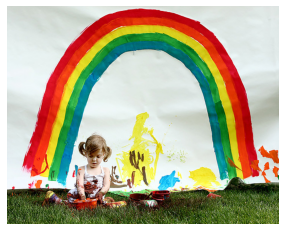

In [12]:
#visualisation of a sample image
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("/content/drive/MyDrive/Image_caption/Flickr8k_Dataset/Flicker8k_Dataset/1002674143_1b742ab4b8.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()

In [35]:
total_img_captions(filename)['1002674143_1b742ab4b8.jpg']#these are 5 captions for this image in our dataset

['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
 'A little girl is sitting in front of a large painted rainbow .',
 'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .',
 'There is a girl with pigtails sitting in front of a rainbow painting .',
 'Young girl with pigtails painting outside in the grass .']

Taking only the unique words in captions

In [36]:
def text_vocabulary(descriptions):
    vocab = set()
    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]

    return vocab

saving all descriptions in one file 

In [37]:
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc )
    data = "\n".join(lines)
    file = open(filename,"w")
    file.write(data)
    file.close()

Importing the dataset from drive

loading the file that contains all data and map them into descriptions dictionary img to 5 captions for each image

In [38]:
descriptions = total_img_captions(filename)
print("Length of descriptions =" , len(descriptions))

Length of descriptions = 8092


cleaning the descriptions to modify into suitable formate

In [39]:
clean_descriptions = cleaning_text(descriptions)

building vocabulary 

In [40]:
vocabulary = text_vocabulary(clean_descriptions)
print("Length of vocabulary = ", len(vocabulary))

Length of vocabulary =  8763


saving each description to file in the directory

In [41]:
save_descriptions(clean_descriptions, "descriptions.txt")

# Extraction of feature vector from all images and save them

In [42]:
def extract_features(directory):
        model = Xception( include_top=False, pooling='avg' )
        features = {}
        for img in tqdm(os.listdir(directory)):
            filename = directory + "/" + img
            image = Image.open(filename)
            image = image.resize((299,299))
            image = np.expand_dims(image, axis=0)
            #image = preprocess_input(image)
            image = image/127.5
            image = image - 1.0

            feature = model.predict(image)
            features[img] = feature
        return features

#2048 feature vector
features = extract_features(dataset_images)
dump(features, open("features.p","wb"))

83697664/83683744 [==============================] - 1s 0us/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/8091 [00:00<?, ?it/s]

In [43]:
features = load(open("/content/features.p","rb"))

Utility functions

In [44]:
#load the data 
def load_photos(filename):
    file = load_document(filename)
    photos = file.split("\n")[:-1]
    return photos

load clean description and add startseq and endseq at the begining and end 

In [45]:
def load_clean_descriptions(filename, photos): 
    #loading clean_descriptions
    file = load_document(filename)
    descriptions = {}
    for line in file.split("\n"):

        words = line.split()
        if len(words)<1 :
            continue

        image, image_caption = words[0], words[1:]

        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = '<startseq> ' + " ".join(image_caption) + ' <endseq>'
            descriptions[image].append(desc)

    return descriptions

load_features of all the image stored in a file creatd above in read binary mode

In [46]:
def load_features(photos):
    #loading all features
    all_features = load(open("/content/features.p","rb"))
    #selecting only needed features
    features = {k:all_features[k] for k in photos}
    return features

In [47]:
filename = dataset_text + "/" + "Flickr_8k.trainImages.txt"#loading the training data captions

#train = loading_data(filename)
train_imgs = load_photos(filename)
train_descriptions = load_clean_descriptions("/content/descriptions.txt", train_imgs)
train_features = load_features(train_imgs)

In [48]:
#converting dictionary to clean list of descriptions
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

In [49]:
#creating tokenizer class 
#this will vectorise text corpus
#each integer will represent token in dictionary

from keras.preprocessing.text import Tokenizer

def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer

give each word an index, and store that into tokenizer.p pickle file

In [50]:
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.p', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
vocab_size

7579

In [51]:
#calculate maximum length of descriptions
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)
    
max_length = max_length(descriptions)
max_length

32

#create input-output sequence pairs from the image description.


In [52]:
#data generator, used by model.fit_generator()
def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
            #retrieve photo features
            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield ([input_image, input_sequence], output_word)

def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

In [53]:
#shape of the input and output for  model
[a,b],c = next(data_generator(train_descriptions, features, tokenizer, max_length))
a.shape, b.shape, c.shape
#((47, 2048), (47, 32), (47, 7577))

((47, 2048), (47, 32), (47, 7579))

In [54]:
from tensorflow.keras.utils import plot_model

# define the captioning model
def define_model(vocab_size, max_length):

    # features from the CNN model squeezed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    # summarize model
    print(model.summary())
    plot_model(model, to_file='/content/drive/MyDrive/Image_caption/model_final/model_diagram.png', show_shapes=True)

    return model

In [55]:
# train our model
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)

Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 7579
Description Length:  32


In [56]:
model = define_model(vocab_size, max_length)
print(model,'model')
epochs = 10
steps = len(train_descriptions)
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save("/content/drive/MyDrive/Image_caption/model_final/model_" + str(i) + ".h5")

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 32, 256)      1940224     input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
______________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


6000/6000 [==============================] - 895s 147ms/step - loss: 5.0066


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


6000/6000 [==============================] - 873s 145ms/step - loss: 2.7986


Bleu Score

In [57]:
def word_for_id(integer, tokenizer):
 for word, index in tokenizer.word_index.items():
     if index == integer:
         return word
 return None

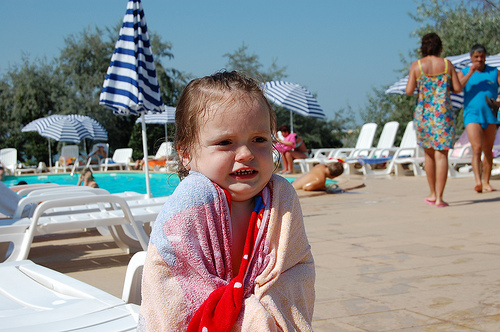

In [58]:
from PIL import Image
img = Image.open('/content/drive/MyDrive/Image_caption/Flickr8k_Dataset/Flicker8k_Dataset/2762301555_48a0d0aa24.jpg')
img

In [59]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.applications.xception import Xception
from keras.models import load_model
from pickle import load
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


In [60]:
img_path='/content/drive/MyDrive/Image_caption/Flickr8k_Dataset/Flicker8k_Dataset/2762301555_48a0d0aa24.jpg'

In [61]:
def extract_features(filename, model):
        try:
            image = Image.open(filename)
            
        except:
            print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
        image = image.resize((299,299))
        image = np.array(image)
        # for images that has 4 channels, we convert them into 3 channels
        if image.shape[2] == 4: 
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        return feature

In [62]:
def word_for_id(integer, tokenizer):
 for word, index in tokenizer.word_index.items():
     if index == integer:
         return word
 return None

In [63]:
def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text




predicted caption=two girls are sitting on the ground and one is smiling


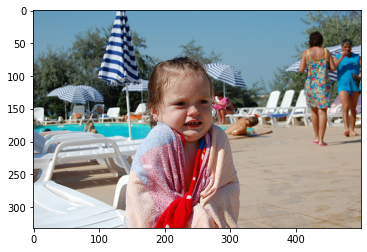

In [64]:
       
max_length = 32
tokenizer = load(open("/content/tokenizer.p","rb"))
model = load_model('/content/drive/MyDrive/Image_caption/model_final/model_9.h5')
xception_model = Xception(include_top=False, pooling="avg")

photo = extract_features(img_path, xception_model)
img = Image.open(img_path)

description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
plt.imshow(img)
#Remove start and end
query = description
stopwords = ['startseq','endseq']
querywords = query.split()

resultwords  = [word for word in querywords if word.lower() not in stopwords]
result = ' '.join(resultwords)
print("predicted caption="+result)
# print(description)


In [71]:
#function to convert the sentence into tokens
def token(text):
  tokens=re.split('\W+',text)
  return tokens

In [66]:
#converting the caption generated into tokens
candidate=token(result)

In [67]:
candidate

['two',
 'girls',
 'are',
 'sitting',
 'on',
 'the',
 'ground',
 'and',
 'one',
 'is',
 'smiling']

In [24]:
test_img_cap=total_img_captions(filename)['2762301555_48a0d0aa24.jpg']

In [75]:
#5 captions of the test image
test_img_cap

['A girl is cold after coming out of the pool and is covered by a towel .',
 'A little girl is covered in a towel at a swimming pool .',
 'a toddler is with wet hair stands by swimming pool wrapped in a towel .',
 'A wet child is shivering in a towel in front of a pool .',
 'A wet child shivers under a towel at a pool .']

In [26]:
test_img_cap[0]

'A girl is cold after coming out of the pool and is covered by a towel .'

In [ ]:
txt='A girl is cold after coming out of the pool and is covered by a towel .'
token(txt)

In [27]:
def token_test_img():
  ref=[]
  for i in range(5):
    ref.append(token(test_img_cap[i]))
  return ref

In [31]:
reference=token_test_img()

In [34]:
reference

[['A',
  'girl',
  'is',
  'cold',
  'after',
  'coming',
  'out',
  'of',
  'the',
  'pool',
  'and',
  'is',
  'covered',
  'by',
  'a',
  'towel',
  ''],
 ['A',
  'little',
  'girl',
  'is',
  'covered',
  'in',
  'a',
  'towel',
  'at',
  'a',
  'swimming',
  'pool',
  ''],
 ['a',
  'toddler',
  'is',
  'with',
  'wet',
  'hair',
  'stands',
  'by',
  'swimming',
  'pool',
  'wrapped',
  'in',
  'a',
  'towel',
  ''],
 ['A',
  'wet',
  'child',
  'is',
  'shivering',
  'in',
  'a',
  'towel',
  'in',
  'front',
  'of',
  'a',
  'pool',
  ''],
 ['A',
  'wet',
  'child',
  'shivers',
  'under',
  'a',
  'towel',
  'at',
  'a',
  'pool',
  '']]

## Bleu score calculation

In [69]:
from nltk.translate.bleu_score import sentence_bleu
ref=reference
cand=candidate
score=sentence_bleu(ref,cand)
print(score)

0.7226568811456053


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [70]:
#cumulative BLEU score calculation using nltk
from nltk.translate.bleu_score import sentence_bleu
ref=reference
cand=candidate
print("cumulative 1-gram : %f"%  sentence_bleu(reference,candidate,weights=(1,0,0,0)))
print("cumulative 2-gram : %f"%  sentence_bleu(reference,candidate,weights=(0.5,0.5,0,0)))
print("cumulative 3-gram : %f"%  sentence_bleu(reference,candidate,weights=(0.33,0.33,0.33,0)))
print("cumulative 4-gram : %f"%  sentence_bleu(reference,candidate,weights=(0.25,0.25,0.25,0.25)))

cumulative 1-gram : 0.272727
cumulative 2-gram : 0.522233
cumulative 3-gram : 0.651314
cumulative 4-gram : 0.722657


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


END OF PROJECT HAVING bleu score of 0.72